We begin by implementing a first-order implicit-explicit (IMEX) scheme to the reaction-diffusion equation,

\begin{align}
  \frac{\partial u}{\partial t} &= \frac{\partial^2 u}{\partial x^2} + \mu\, u (1-u)^2,
  \quad x\in[0,1], \quad t\in(0,2],\\
  u(t,0) &= u(t,1)=0, \quad u(0,x) = x(1-x).
\end{align}

We handle the diffusion term implicitly and the reaction term explicitly, i.e., 

\begin{align*}
  \frac{u^{n+1}_i - u^{n}_i}{\Delta t} = 
  \frac{u^{n+1}_{i+1} - 2u^{n+1}_i + u^{n+1}_{i-1}}{\Delta x^2} + \mu\, u^n_i (1-u^n_i)^2,
\end{align*}

where we have used a centered finite difference to approximate $u_{xx}$.

In [1]:
using LinearAlgebra, Plots

In [2]:
#homegrown polyfit code
function vander!(V::AbstractMatrix, x::AbstractVector, n=length(x))
    m = length(x)
    (m,n) == size(V) || throw(DimensionMismatch())
    for j = 1:m
        @inbounds V[j,1] = one(x[j])
    end
    for i = 2:n, j = 1:m
        @inbounds V[j,i] = x[j] * V[j,i-1]
    end
    return V
end
vander(x::AbstractVector, n=length(x)) = vander!(Array{eltype(x)}(undef, length(x), n), x, n)

function polyfit!(x::AbstractVector, y::AbstractVector, n)
    return vander(x,n+1)\y
end
polyfit(x::AbstractVector, y::AbstractVector, n) = polyfit!(x, y,n)

polyfit (generic function with 1 method)

In [3]:
function rf(u, dx, μ) # right hand side of the PDE
    n = length(u)
    α = 1/dx^2 
    diagonal = fill(-2 * α, n)
    off_diagonal = fill(α, n-1)
    D = Tridiagonal(off_diagonal, diagonal, off_diagonal)
    
    return D*u + μ .*u .* (1 .- u) .^2
end

rf (generic function with 1 method)

In [4]:
function fn(u,dx,mu)
    # does not depend explicit on t for this example
    # computes mu*u(1-u^2)
    return (mu .* u .* (1 .- u) .^ 2 )
end

fn (generic function with 1 method)

In [5]:
function fs(u,dx)
    # does not depend explicit on t for this example
    # here: approximates D_xx u
    n = length(u)
    alpha = 1/dx^2
    D = Array(Tridiagonal(fill(alpha,n-1),fill(-2*alpha,n),fill(alpha,n-1)))
    
    return D*u
end

fs (generic function with 1 method)

In [6]:
function imex_step(mu, dx, dt, un, N) # This represents the predictor solution
    # inputs:
    # mu: problem parameter for the reaction term
    # dx, dt: spatial and time discretization
    # un: solution at time t(n)
    # N: number of time intervals
    # output: solution at time t(n+1)

    # assemble Au = f, where u is the unknown solution at time t(n+1)
    n = length(un)
    alpha = dt / dx^2
    A = Array(Tridiagonal(fill(-alpha, n-1), fill(1+2*alpha, n), fill(-alpha, n-1)))
    
    u_result = zeros(M, N+1)
    u_result[:, 1] = u0
    for i in 1:N
        f = un .+ dt .* fn(un, dx, mu)
        u_result[:, i+1] = A \ f
        un = u_result[:, i+1]
    end

    return u_result
end

imex_step (generic function with 1 method)

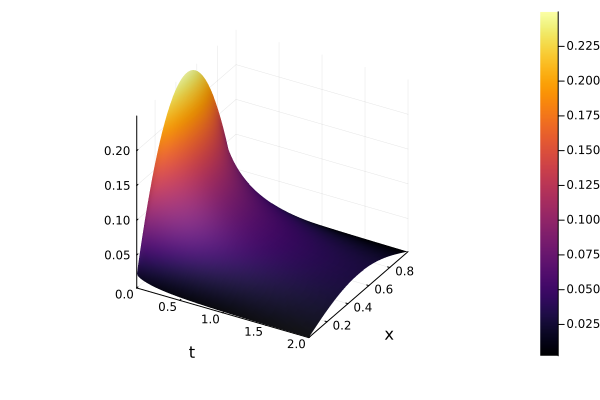

In [7]:
# Test IMEX
# Parameters
N = 1000  # number of time intervals
M = 40   # number of (interior) spatial grid points

tspan = [0 2.0]
dt = (tspan[2] - tspan[1]) / N
dx = 1.0 / (M+1)
x = (1:M) .* dx
t = (0:N) .* dt

u0 = x .* (1 .- x)

# Call the function
u_result = imex_step(10, dx, dt, u0, N)

# Plot the result
surface(t, x, u_result, xlabel="t", ylabel="x")

In [8]:
function RIDC(N, tspan, u0, dx, P)
    

    dt = (tspan[2] - tspan[1]) / N
    M = length(u0)
    u = zeros(M, N+1, P)
    u[:, 1, 1] .= u0  # Initial condition for the predictor

    # Define imex_corr_step function
    function imex_corr_step(mu, dx, dt, un, up, weights)
        n = length(un)
        alpha = dt / dx^2
        A = Tridiagonal(fill(-alpha, n-1), fill(1+2*alpha, n), fill(-alpha, n-1))
        quad_approx = zeros(size(un))

        for j in 1:length(weights)
            quad_approx .+= weights[j] * (fs(up[:, j], dx) .+ fn(up[:, j], dx, mu))
        end

        f = un .+ dt .* fn(un, dx, mu) .- dt .* fs(up[:, end], dx) .- dt .* fn(up[:, end-1], dx, mu) .+ quad_approx
        return A \ f
    end

    # Predictor step
    
        u[:, :, 1] .= imex_step(10, dx, dt, u0, N)
   

    # Storing weights manually, not a great way but initially its fine for now
    
    # Hard coded corrector weights function
    function get_corrector_weights(p, dt)
        if p == 1
            return [0.5*dt; 0.5*dt]
        elseif p == 2
            return [5.0/12*dt;  2.0/3*dt; -1.0/12*dt;]
        # Add more conditions for other values of p if needed
        elseif p==3
            return [1.0/24 * dt, -9.0/8 * dt, 9.0/8 * dt, -1.0/24 * dt]
        else
            error("Unsupported value of p: $p")
        end
    end
    
    
    # Corrector steps
    for p in 1:P-1
        u[:, 1, p+1] .= u0 # initial condition for the next iteration
        weights = get_corrector_weights(p, dt)  # Function to calculate corrector weights
      
    # First nth steps of corrector
        for n in 2:p
            mu = 10
            alpha = dt/dx^2
            A = Array(Tridiagonal(fill(-alpha,M-1),fill(1+2*alpha,M),fill(-alpha,M-1)))
            quad_approx = zeros(M,1)
            
            for j = 1:length(weights)
                quad_approx += weights[j]*(fs(u[:,j,p],dx) .+ fn(u[:,j,p],dx,mu))
            end
        
            f = u[:,n-1,p+1] .+ dt .* fn(u[:,n-1,p+1],dx,mu) .- dt .* fs(u[:,n,p],dx) .- dt .* fn(u[:,n-1,p],dx,mu) .+ quad_approx 
            u[:,n,p+1]  = A\f 
            
        end
        
        # Switching weights
        if p==2
            weights = [-1.0/12*dt; 2.0/3*dt; 5.0/12*dt]
        elseif p==3
            [-1.0/24 * dt, 9.0/8 * dt, -9.0/8 * dt, 1.0/24 * dt]
        end
        
        
        for n in (p+1):(N+1)
        u[:, n, p+1] .= imex_corr_step(10, dx, dt, u[:, n-1, p+1], u[:, n-p:n, p], weights)
        end
        
    end

    return u
end

RIDC (generic function with 1 method)

convergence order = 0.9845441790224285
convergence order = 1.8968038975129942
convergence order = 2.9588429332115758


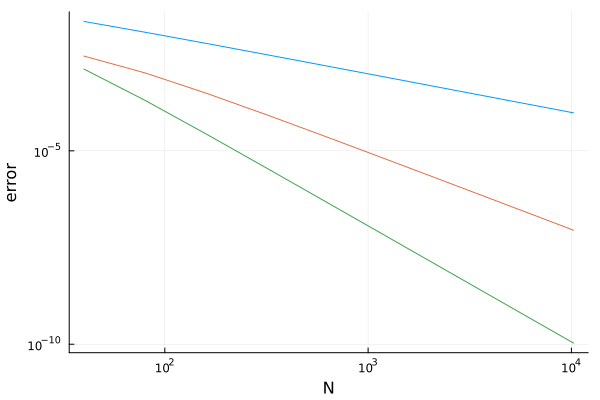

In [9]:
M = 40  # number of (interior) spatial grid points
tspan = [0 2.0]
dx = 1.0 / (M + 1)
x = (1:M) .* dx
u0 = x .* (1 .- x)
P=3
# Convergence study in time
K = 10
err = zeros(K-1, P)  # we will compare successive solutions
nstore = zeros(K-1, 1)
#u_store = zeros(M, P)

# Pth order convergence analysis
for p in 1: P
    u_store = zeros(M, K, P)  # Initialize u_store 
    
    for k in 1:K
        N = 20 * 2^k  # number of time intervals
        dt = (tspan[2] - tspan[1]) / N
        u_r = RIDC(N, tspan, u0, dx, P)  # Pass P to your RIDC function
        u_store[:, k, p] .= copy(u_r[:, end, p])
    end
    # Storing the Error
    for j in 2:K
        err[j-1, p]=norm(u_store[:, j, p] - u_store[:, j-1, p])
        nstore[j-1] = 20 * 2^(j-1)  # Store N values for analysis
    end
     
    # convergence order
     p = polyfit(log10.(nstore[:]), log10.(err[:, p]), 1)
     print("convergence order = ", abs(p[2]), "\n")
end

# Error Plot
plot(nstore, err, xaxis=:log, yaxis=:log, xlabel="N", ylabel="error", legend=false)